# Evaluations

This notebook is used to produce *baselines* for the GaussianProxy models (data vs data FID / classifier scores / CellProfiler correlations).

---

# Imports

In [18]:
import json
import random
from pathlib import Path
from pprint import pprint
from warnings import warn

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import torch
import torch_fidelity
from torch.utils.data import Subset
from torchvision.transforms import Compose, ConvertImageDtype, RandomHorizontalFlip, RandomVerticalFlip
from tqdm.notebook import tqdm, trange

from GaussianProxy.utils.data import RandomRotationSquareSymmetry

In [19]:
torch.set_grad_enabled(False)

In [20]:
sns.set_theme(context="paper")

# Dataset

In [21]:
from my_conf.dataset.BBBC021_196_docetaxel_inference import BBBC021_196_docetaxel_inference as dataset

In [22]:
assert dataset.dataset_params is not None
database_path = Path(dataset.path)
print(f"Using dataset {dataset.name} from {database_path}")
subdirs: list[Path] = [e for e in database_path.iterdir() if e.is_dir() and not e.name.startswith(".")]
subdirs.sort(key=dataset.dataset_params.sorting_func)

# now split the dataset into 2 non-overlapping parts, respecting classes proportions...
# ...and repeat that 10 times to get std of the metric
is_flip_or_rotation = lambda t: isinstance(t, (RandomHorizontalFlip, RandomVerticalFlip, RandomRotationSquareSymmetry))
flips_rot = [t for t in dataset.transforms.transforms if is_flip_or_rotation(t)]
transforms = Compose(flips_rot + [ConvertImageDtype(torch.uint8)])
print(f"Using transforms:\n{transforms}")

Using dataset BBBC021_196_docetaxel from /projects/static2dynamic/datasets/BBBC021/196x196/docetaxel
Using transforms:
Compose(
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotationSquareSymmetry()
    ConvertImageDtype()
)


In [23]:
nb_repeats = 10

In [24]:
exp_repeats = {}
nb_elems_per_class = {}

for exp_rep in trange(nb_repeats):
    ds1_elems = []
    ds2_elems = []
    for subdir in subdirs:
        this_class_elems = list(subdir.glob(f"*.{dataset.dataset_params.file_extension}"))
        nb_elems_per_class[subdir.name] = len(this_class_elems)
        random.shuffle(this_class_elems)
        ds1_elems += this_class_elems[: len(this_class_elems) // 2]
        ds2_elems += this_class_elems[len(this_class_elems) // 2 :]

    assert abs(len(ds1_elems) - len(ds2_elems)) <= len(subdirs)
    ds1 = dataset.dataset_params.dataset_class(
        ds1_elems,
        transforms,
        dataset.expected_initial_data_range,
    )
    ds2 = dataset.dataset_params.dataset_class(
        ds2_elems,
        transforms,
        dataset.expected_initial_data_range,
    )
    exp_repeats[f"exp_rep_{exp_rep}"] = {"split1": ds1, "split2": ds2}

nb_elems_per_class["all_classes"] = sum(nb_elems_per_class.values())
pprint(exp_repeats)

  0%|          | 0/10 [00:00<?, ?it/s]

{'exp_rep_0': {'split1': ImageDataset
    Number of datapoints: 2394
    Expected initial data range: (0, 255),
               'split2': ImageDataset
    Number of datapoints: 2399
    Expected initial data range: (0, 255)},
 'exp_rep_1': {'split1': ImageDataset
    Number of datapoints: 2394
    Expected initial data range: (0, 255),
               'split2': ImageDataset
    Number of datapoints: 2399
    Expected initial data range: (0, 255)},
 'exp_rep_2': {'split1': ImageDataset
    Number of datapoints: 2394
    Expected initial data range: (0, 255),
               'split2': ImageDataset
    Number of datapoints: 2399
    Expected initial data range: (0, 255)},
 'exp_rep_3': {'split1': ImageDataset
    Number of datapoints: 2394
    Expected initial data range: (0, 255),
               'split2': ImageDataset
    Number of datapoints: 2399
    Expected initial data range: (0, 255)},
 'exp_rep_4': {'split1': ImageDataset
    Number of datapoints: 2394
    Expected initial data range

# FID

## Compute train vs train FIDs

In [25]:
def compute_metrics(batch_size: int, metrics_save_path: Path):
    eval_metrics = {}

    for exp_rep in tqdm(exp_repeats, unit="experiment repeat"):
        metrics_dict: dict[str, dict[str, float]] = {}
        metrics_dict["all_classes"] = torch_fidelity.calculate_metrics(
            input1=exp_repeats[exp_rep]["split1"],
            input2=exp_repeats[exp_rep]["split2"],
            cuda=True,
            batch_size=batch_size,
            isc=True,
            fid=True,
            prc=True,
            verbose=True,
            samples_find_deep=True,
        )
        # per-class
        for subdir in subdirs:
            ds1_this_cl = Subset(
                exp_repeats[exp_rep]["split1"], [i for i, e in enumerate(ds1_elems) if e.parent == subdir]
            )
            ds2_this_cl = Subset(
                exp_repeats[exp_rep]["split2"], [i for i, e in enumerate(ds2_elems) if e.parent == subdir]
            )
            if exp_rep == "exp_rep_0":
                print(f"Will use {len(ds1_this_cl)} and {len(ds2_this_cl)} elements for splits of class {subdir.name}")
            assert abs(len(ds1_this_cl) - len(ds2_this_cl)) <= 1
            assert len(ds1_this_cl) + len(ds2_this_cl) == nb_elems_per_class[subdir.name]
            metrics_dict_cl = torch_fidelity.calculate_metrics(
                input1=ds1_this_cl,
                input2=ds2_this_cl,
                cuda=True,
                batch_size=batch_size,
                isc=True,
                fid=True,
                prc=True,
                verbose=True,
            )
            metrics_dict[subdir.name] = metrics_dict_cl
        eval_metrics[exp_rep] = metrics_dict  # for saving to json

    if metrics_save_path.exists():
        raise RuntimeError(f"File {metrics_save_path} already exists, not overwriting")
    if not metrics_save_path.parent.exists():
        metrics_save_path.parent.mkdir(parents=True)
    with open(metrics_save_path, "w") as f:
        json.dump(eval_metrics, f)

In [26]:
batch_size = 512
metrics_save_path = Path(f"evaluations/{dataset.name}/eval_metrics.json")

In [27]:
recompute = False

In [28]:
if recompute:
    inpt = input("Confirm recompute (y/[n]):")
    if inpt != "y":
        warn(f"Will not recompute but load from {metrics_save_path}")
        with open(metrics_save_path, "r") as f:
            eval_metrics = json.load(f)
    else:
        warn("Will recompute")
        compute_metrics(batch_size, metrics_save_path)
else:
    warn(f"Will not recompute but load from {metrics_save_path}")
    with open(metrics_save_path, "r") as f:
        eval_metrics = json.load(f)

/localtmp/tboyer/.tmpdir/ipykernel_2655881/1716591089.py:11: UserWarning:

Will not recompute but load from evaluations/BBBC021_196_docetaxel/eval_metrics.json



In [29]:
pprint(eval_metrics)

{'exp_rep_0': {'0.0003': {'frechet_inception_distance': 18.95410614252407,
                          'inception_score_mean': 1.7253417182143636,
                          'inception_score_std': 0.1502877220490709},
               '0.001': {'frechet_inception_distance': 24.721903391428157,
                         'inception_score_mean': 1.846066338088433,
                         'inception_score_std': 0.12441346071587762},
               '0.003': {'frechet_inception_distance': 29.460609665640476,
                         'inception_score_mean': 1.9080115284417005,
                         'inception_score_std': 0.15897472216390227},
               '0.01': {'frechet_inception_distance': 31.46903042462452,
                        'inception_score_mean': 1.9153092575889328,
                        'inception_score_std': 0.23609894635077297},
               '0.03': {'frechet_inception_distance': 28.814193530574272,
                        'inception_score_mean': 1.6716375304897386,
      

In [30]:
# Extract class names and FID scores for training data vs training data
class_names = list(eval_metrics["exp_rep_0"].keys())
fid_scores_by_class_train = {class_name: [] for class_name in class_names}

for exp_rep in eval_metrics.values():
    for class_name in class_names:
        fid_scores_by_class_train[class_name].append(exp_rep[class_name]["frechet_inception_distance"])

pprint(fid_scores_by_class_train)

{'0.0003': [18.95410614252407,
            18.863447090427314,
            18.912127498068628,
            19.009885123268504,
            19.04765387414386,
            18.64992844400274,
            18.900884738933485,
            19.446146608117658,
            18.760227495528113,
            19.21136105590594],
 '0.001': [24.721903391428157,
           24.860038794228416,
           25.364531753194797,
           24.685357851122887,
           25.300016779199666,
           24.489615767740162,
           24.305539536295555,
           24.491975931442767,
           24.434092814974463,
           24.21349006111751],
 '0.003': [29.460609665640476,
           29.617363198848835,
           31.00789698187009,
           29.445371776290642,
           29.335490554622254,
           30.439643945031406,
           30.231042408101445,
           31.026612403973616,
           29.106776890594006,
           29.611086309311844],
 '0.01': [31.46903042462452,
          31.8054493255963,
      

## Load gen vs train FIDs

This is done in `inference.py` script

In [65]:
saved_FIDs_generation_path = Path(
    "/",
    "projects",
    "static2dynamic",
    "Thomas",
    "experiments",
    "GaussianProxy",
    "BBBC021_196_docetaxel_4M_net_SAVED_MODEL_MISMATCH",  # change here
    "inferences",
    "FIDComputation_50_diffsteps",  # change here
    "metrics.json",
)

In [66]:
# Extract FID scores on generated data vs training data
with open(saved_FIDs_generation_path, "r") as f:
    fid_scores_by_class_gen = json.load(f)
pprint(fid_scores_by_class_gen)

{'0.0003': {'frechet_inception_distance': 88.51519978959445,
            'inception_score_mean': 1.8631795993614548,
            'inception_score_std': 0.09232220056540451},
 '0.001': {'frechet_inception_distance': 73.64475518657272,
           'inception_score_mean': 1.8893963745957787,
           'inception_score_std': 0.10599053586169287},
 '0.003': {'frechet_inception_distance': 42.76327722604688,
           'inception_score_mean': 1.860974091336205,
           'inception_score_std': 0.09111696637803696},
 '0.01': {'frechet_inception_distance': 42.73245897723277,
          'inception_score_mean': 1.901084395198546,
          'inception_score_std': 0.15780698399000842},
 '0.03': {'frechet_inception_distance': 31.53402754341441,
          'inception_score_mean': 1.7359301376811764,
          'inception_score_std': 0.08753921097890205},
 '0.1': {'frechet_inception_distance': 32.361423997051716,
         'inception_score_mean': 1.8273801946846955,
         'inception_score_std': 0.1166

## Plot

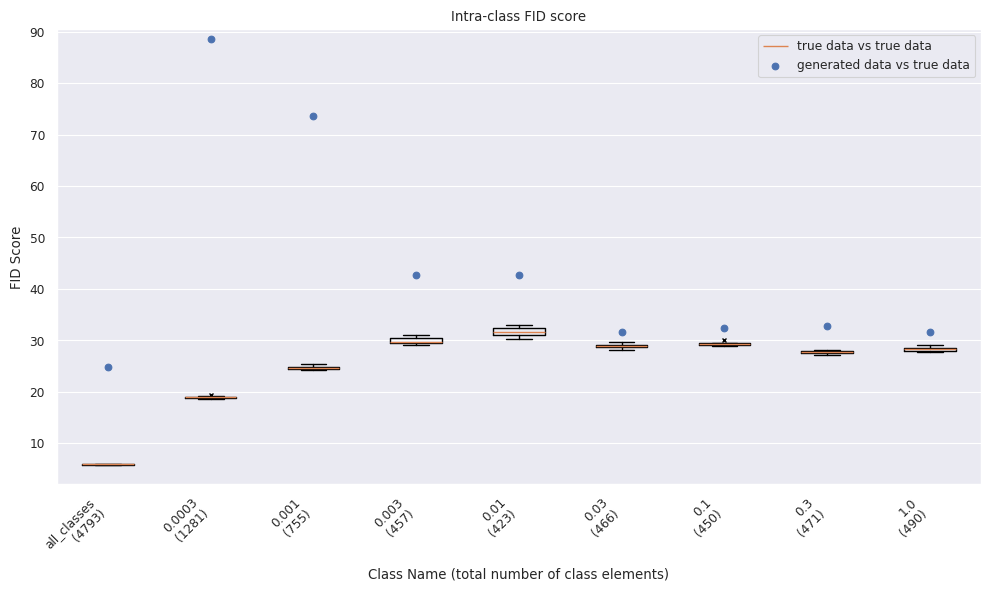

In [67]:
plt.figure(figsize=(10, 6))
class_labels = [f"{class_name}\n({nb_elems_per_class[class_name]})" for class_name in class_names]
plt.boxplot(
    [fid_scores_by_class_train[class_name] for class_name in class_names],
    tick_labels=class_labels,
    showfliers=True,
    flierprops=dict(marker="x", markersize=3),
    label="true data vs true data",
)
plt.scatter(
    x=range(1, len(class_names) + 1),
    y=[fid_scores_by_class_gen[cl_name]["frechet_inception_distance"] for cl_name in class_names],
    label="generated data vs true data",
)
plt.xlabel("Class Name (total number of class elements)")
plt.ylabel("FID Score")
plt.title("Intra-class FID score")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="x")
plt.legend()
plt.tight_layout()
plt.ylim(2, 90.5)
plt.show()

In [68]:
fig = go.Figure()

# train
corresp_x_values = []
y_vals = []
for cl_name in class_names:
    corresp_x_values += [cl_name] * nb_repeats
    y_vals += fid_scores_by_class_train[cl_name]
fig.add_trace(
    go.Box(
        y=y_vals,
        x=corresp_x_values,
        name="train vs train",
    )
)

# gen
corresp_x_values = list(fid_scores_by_class_gen.keys())
y_vals = [fid_scores_by_class_gen[cl_name]["frechet_inception_distance"] for cl_name in corresp_x_values]
fig.add_trace(
    go.Box(
        y=y_vals,
        x=corresp_x_values,
        name="gen vs train",
    )
)

fig.update_layout(
    yaxis_title="FID Score",
    boxmode="group",
    xaxis_title="Class Name (total number of class elements)",
    title="Intra-class FID score",
    xaxis=dict(
        tickmode="array",
        tickvals=list(range(len(class_names))),
        ticktext=[f"{class_name}<br>({nb_elems_per_class[class_name]})" for class_name in class_names],
        tickangle=-45,
    ),
    height=700,
)
fig.show()